# Grover Search Algorithm Example

We implement a permutation
\begin{align*}
    (0~~2) =
    \begin{pmatrix}
        0 & 1 & 2 & 3 \\
        2 & 1 & 0 & 3
    \end{pmatrix}
\end{align*}
on a quantum circuit with $4+4$ qubits:
\begin{align*}
    & f\colon x_3x_2x_1x_0 \mapsto x_3x_0x_1x_2, \quad x_0,x_1,x_2,x_3\in\{0,1\},\\[.5em]
    & U_f\colon |x_3x_2x_1x_0\rangle|0000\rangle \mapsto |x_3x_2x_1x_0\rangle|f(x_3x_2x_1x_0)\rangle.
\end{align*}
In what follows, we assume that the function $f$ implemented on the circuit is not explicitly defined, i.e., the gate $U_f$ is treated as an oracle.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile
from qiskit.circuit.library import XGate, GroverOperator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import copy

In [2]:
backend = AerSimulator()

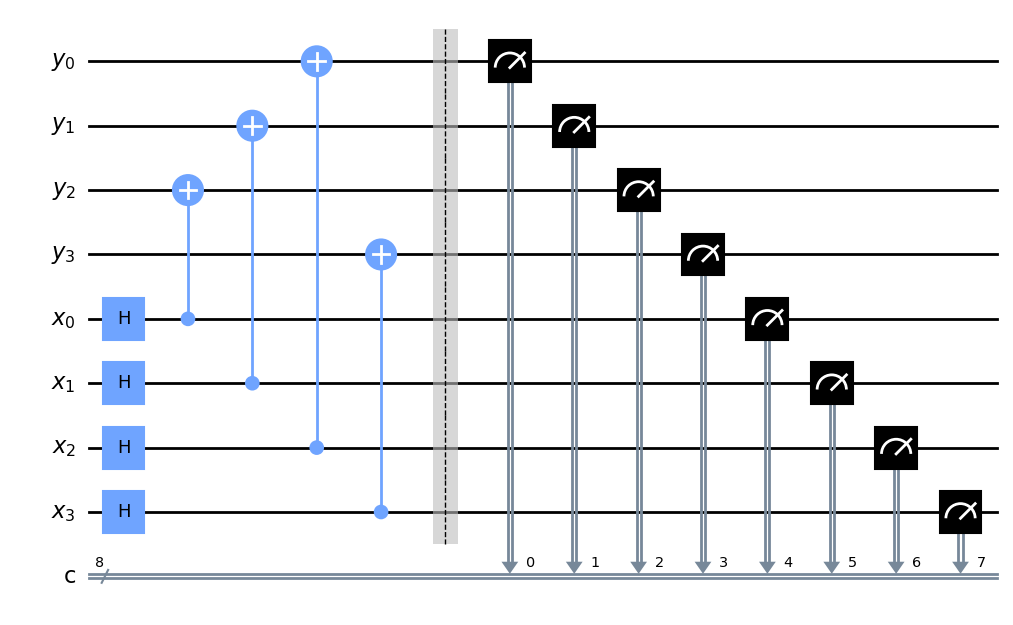

In [3]:
N = 4
nx_qubits, ny_qubits = N, N
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qc = QuantumCircuit(qr_y, qr_x)

# |x3>|x2>|x1>|x0>|0000> -> |x3>|x2>|x1>|x0>|x3>|x0>|x1>|x2>
for i in range(nx_qubits):
    qc.h(i + ny_qubits)
for i in range(nx_qubits):
    qc.cx(i + ny_qubits, (ny_qubits - 2 - i) % ny_qubits)

qc.barrier()
cr = ClassicalRegister(nx_qubits + ny_qubits, 'c')
qc.add_register(cr)
qc.measure(list(range(nx_qubits + ny_qubits)), cr)
qc.draw('mpl')

{'10111110': 603, '00110110': 675, '01000001': 653, '01100011': 626, '11111111': 608, '10001000': 600, '00100010': 624, '10011100': 644, '11011101': 653, '01010101': 604, '11101011': 617, '01110111': 620, '00010100': 602, '10101010': 625, '00000000': 622, '11001001': 624}


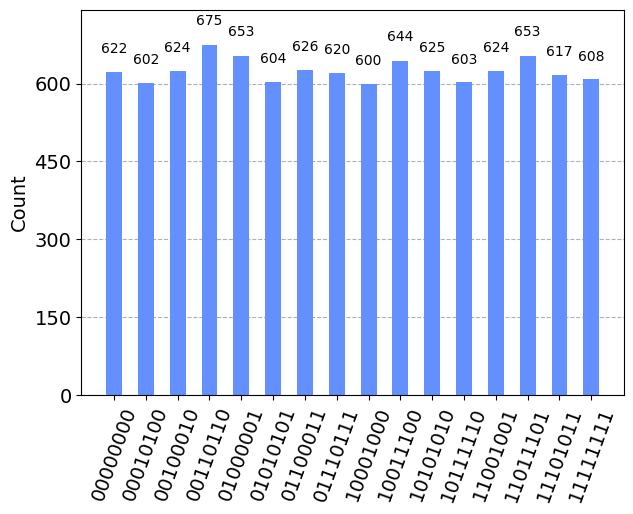

In [4]:
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_histogram(counts)

As an example, we search for a bitstring where $f$ attains $1100$.
We introduce additional ancilla qubits, and flip qubit No. 0 ("marker") to $|1\rangle$ when $f$ attains $1100$.
The circuit diagram for this is as follows.

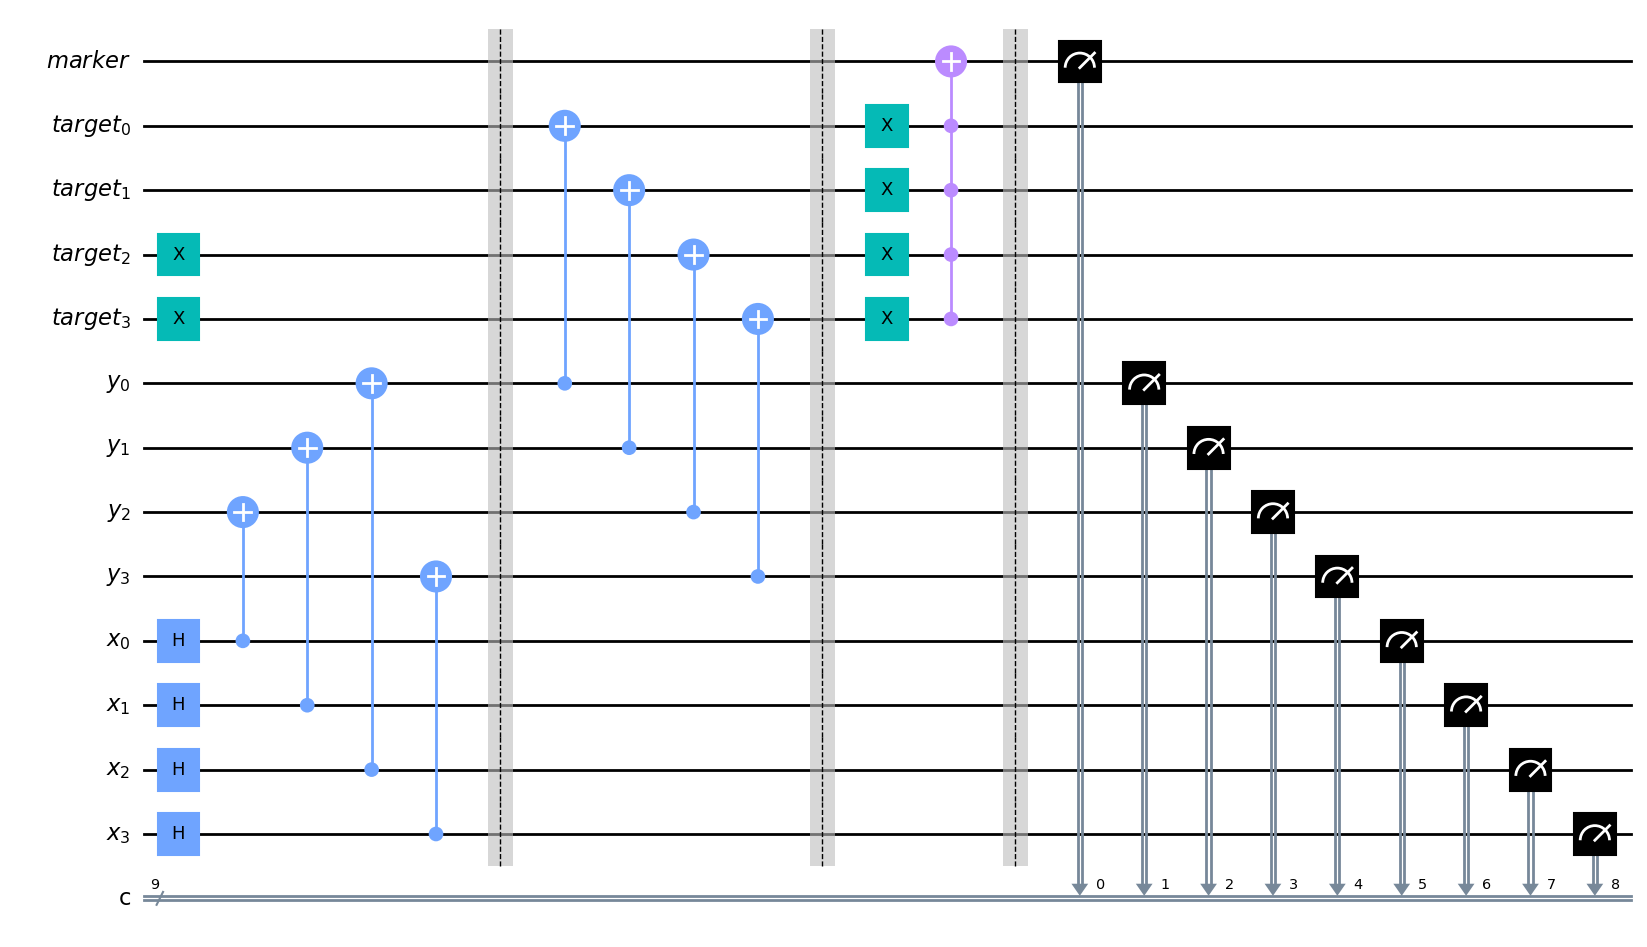

In [5]:
n_targets = nx_qubits
n_markers = 1
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qr_target = QuantumRegister(n_targets, 'target')
qr_marker = QuantumRegister(n_markers, 'marker')
qc = QuantumCircuit(qr_marker, qr_target, qr_y, qr_x)

# |x3>|x2>|x1>|x0>|0000> -> |x3>|x2>|x1>|x0>|x3>|x0>|x1>|x2>
for i in range(nx_qubits):
    qc.h(i + ny_qubits + n_targets + n_markers)
for i in range(nx_qubits):
    qc.cx(i + ny_qubits + n_targets + n_markers, (ny_qubits - 2 - i) % ny_qubits + n_targets + n_markers)


# target: |1100>
qc.x(n_markers + 2)
qc.x(n_markers + 3)

# check if equality
qc.barrier()
for i in range(nx_qubits):
    qc.cx(i + n_targets + n_markers, i + n_markers)

# marking on the qubit "marker"
qc.barrier()
for i in range(n_targets):
    qc.x(i + n_markers)
c4x_gate = XGate().control(4)
qc.append(c4x_gate, qargs=list(reversed(range(n_targets + n_markers))))

qc.barrier()
# cr = ClassicalRegister(n_markers, 'c')
# qc.add_register(cr)
# qc.measure(0, cr)
cr = ClassicalRegister(n_markers + nx_qubits + ny_qubits, 'c')
qc.add_register(cr)
qc.measure([0, 5, 6, 7, 8, 9, 10, 11, 12], cr)

qc.draw('mpl')
# qc.draw('mpl', filename='test.jpg')

{'000101000': 597, '010101010': 637, '011101110': 634, '100010000': 607, '001101100': 635, '101111100': 628, '110111010': 639, '111111110': 620, '101010100': 633, '000000000': 635, '110010010': 627, '111010110': 667, '001000100': 591, '100111001': 601, '010000010': 620, '011000110': 629}


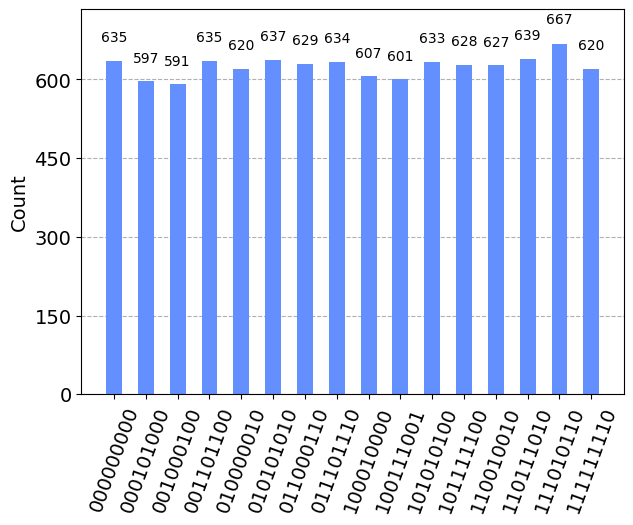

In [6]:
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_histogram(counts)
# plot_histogram(counts, filename='test.jpg')

In the following, we set a Grover operator $Q$ for this problem.
The state preparation gate is the same as the one used above, and is as follows:

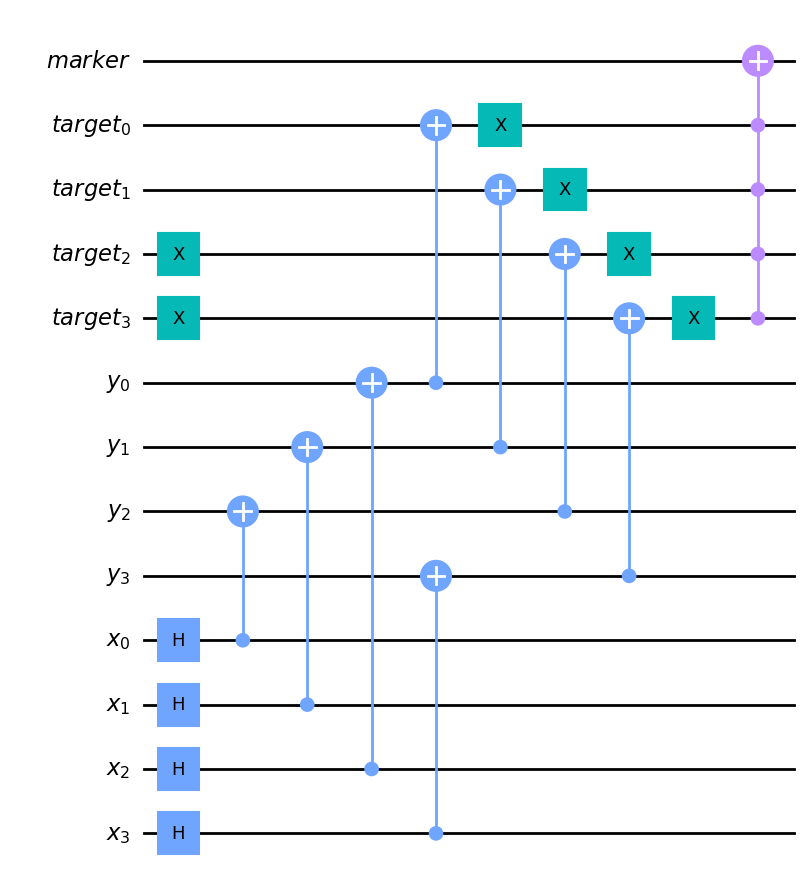

In [7]:
insert_barrier = False

qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qr_target = QuantumRegister(n_targets, 'target')
qr_marker = QuantumRegister(n_markers, 'marker')
qc = QuantumCircuit(qr_marker, qr_target, qr_y, qr_x)

# |x3>|x2>|x1>|x0>|0000> -> |x3>|x2>|x1>|x0>|x3>|x0>|x1>|x2>
for i in range(nx_qubits):
    qc.h(i + ny_qubits + n_targets + n_markers)
for i in range(nx_qubits):
    qc.cx(i + ny_qubits + n_targets + n_markers, (ny_qubits - 2 - i) % ny_qubits + n_targets + n_markers)


# target: |1100>
qc.x(n_markers + 2)
qc.x(n_markers + 3)

# check if equality
if insert_barrier: qc.barrier()
for i in range(nx_qubits):
    qc.cx(i + n_targets + n_markers, i + n_markers)

# marking on the qubit "marker"
if insert_barrier: qc.barrier()
for i in range(n_targets):
    qc.x(i + n_markers)
c4x_gate = XGate().control(4)
qc.append(c4x_gate, qargs=list(reversed(range(n_targets + n_markers))))

qc.draw('mpl')

Set a Grover operator $Q$.

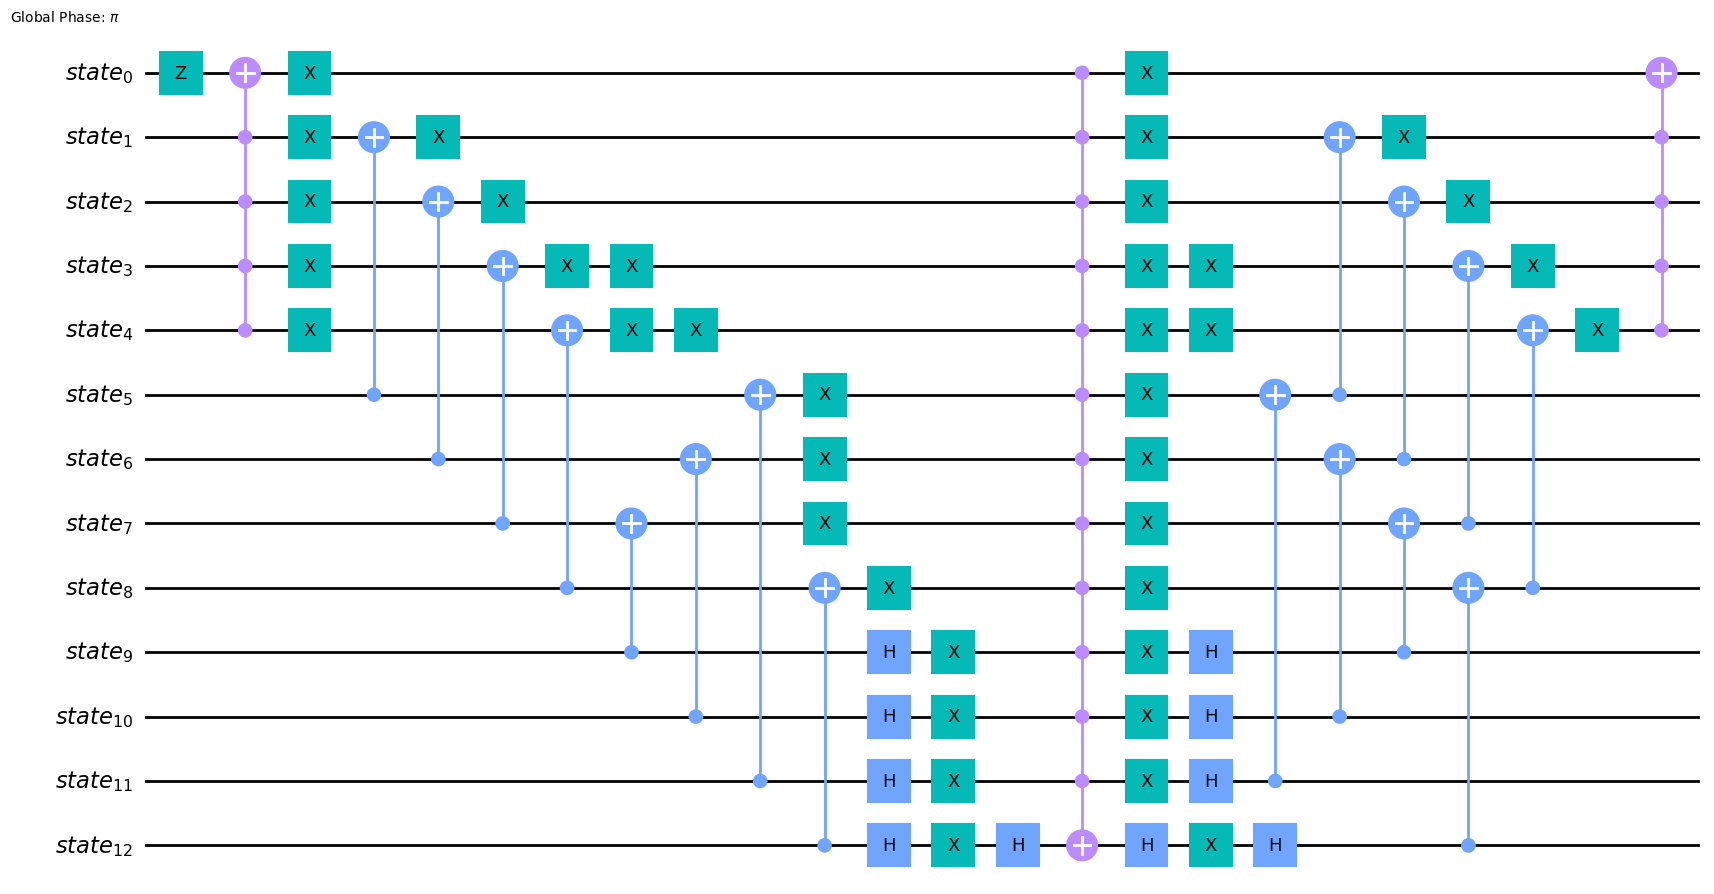

In [8]:
oracle = QuantumCircuit(n_targets + n_markers + nx_qubits + ny_qubits)
oracle.z(0)
Q = GroverOperator(oracle, state_preparation=qc, insert_barriers=insert_barrier)
Q.decompose().draw('mpl')

The number of iterations for $Q$ is $\lfloor \pi/(4\arcsin 2^{-4}) \rfloor=3$ since the probability of  observing $|1100\rangle$ is $1/2^4$.

number of iterations: 3


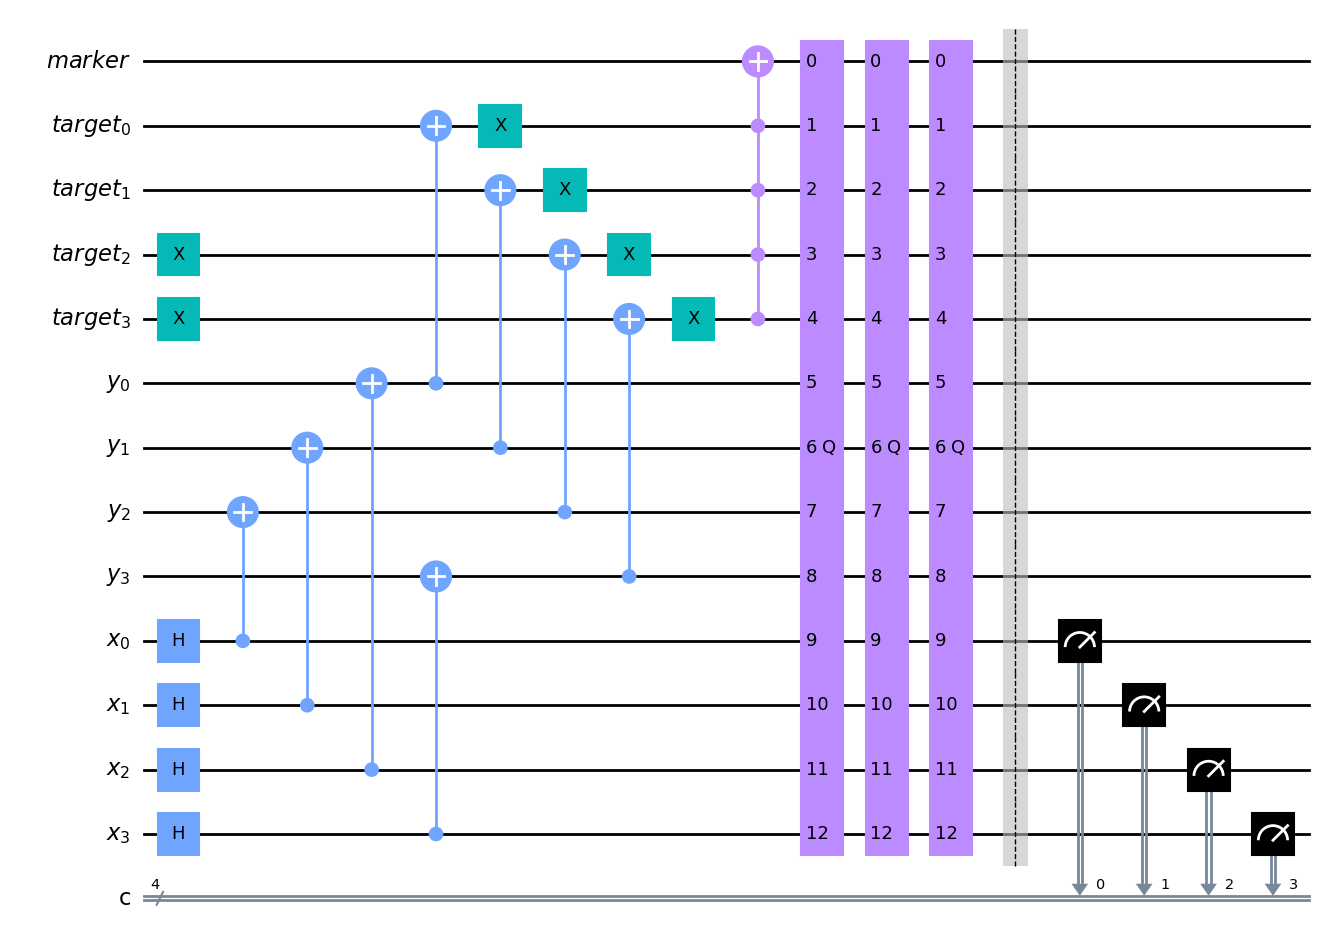

In [9]:
_qc = copy.deepcopy(qc)
n_iter = int(np.floor(np.pi / 4 / np.arcsin(np.sqrt(1 / 2 ** nx_qubits))))
print(f'number of iterations: {n_iter}')

for i in range(n_iter):
    _qc.append(Q.to_gate(), qargs=list(range(n_targets + n_markers + nx_qubits + ny_qubits)))

_qc.barrier()
cr = ClassicalRegister(nx_qubits, 'c')
_qc.add_register(cr)
_qc.measure([9, 10, 11, 12], cr)

_qc.draw('mpl')

{'1001': 9625, '0011': 34, '0010': 22, '1000': 28, '1110': 26, '0101': 30, '0111': 25, '1101': 29, '1111': 20, '0100': 22, '0110': 19, '0001': 22, '1100': 22, '1011': 31, '1010': 25, '0000': 20}


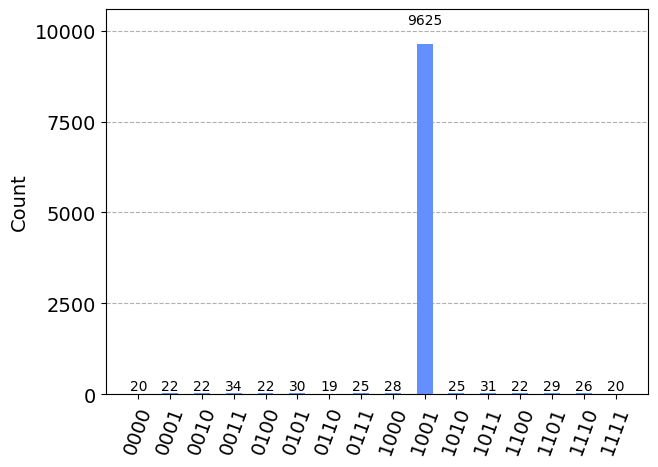

In [10]:
qc_compiled = transpile(_qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_histogram(counts)